# SHAP Example Notebook
This notebook uses an example from ECE 285 and provides a method of generating SHAP values on a US Census dataset to determine the most impactful features for classification. The steps are as follows:
1. Import dataset and do a train-test split using sklearn
2. Generate a random forest classifier which can be used to quickly compute SHAP values
3. Create an explainer object which calculates SHAP values of each feature to rank their importance in the random forest classifier
4. Plot the most important features and their SHAP distributions
5. Filter by the top k features and train models on it
6. Test models on filtered feature space and compare to models on all features

In [1]:
import shap
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

In [2]:
X, y = shap.datasets.adult()
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(32561, 12) (32561,)
(26048, 12) (6513, 12) (26048,) (6513,)


In [3]:
model = RandomForestClassifier(
    n_estimators=3,
    max_depth=8,
    random_state=42
)
model.fit(X_train, y_train)

print(f"Train accuracy: {model.score(X_train, y_train):.3f}")
print(f"Test accuracy: {model.score(X_test, y_test):.3f}")

Train accuracy: 0.861
Test accuracy: 0.857


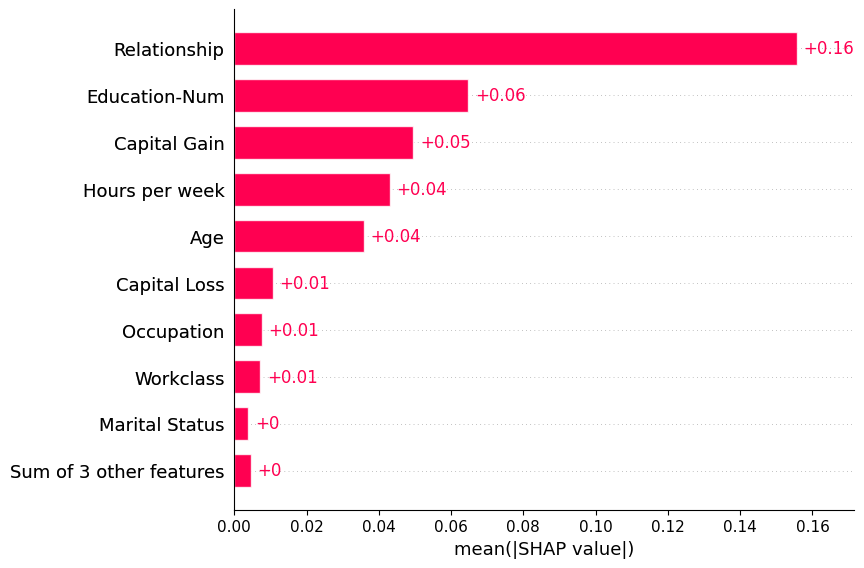

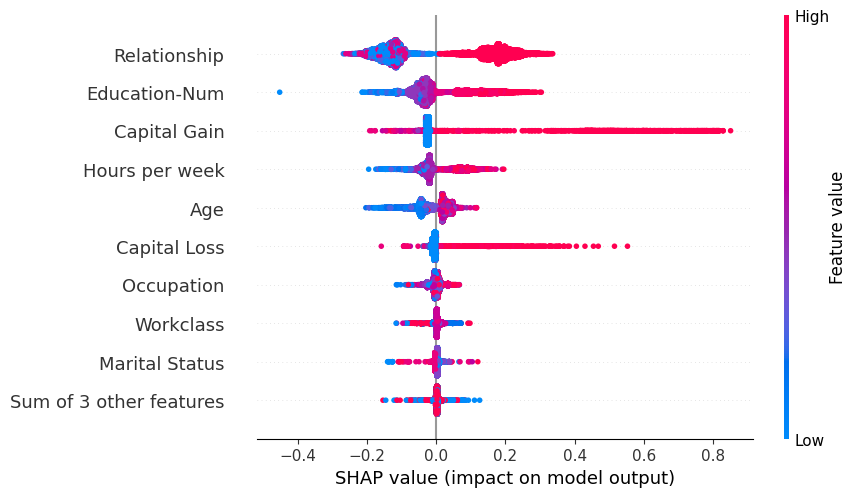

In [4]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# The TreeExplainer output is an arrays with shape (n_samples, n_features, n_outputs).
# So we first have to onvert the raw shap_values (numpy array) into a shap.Explanation object expected by shap.plots.*
# Also note that for a binary classifier we commonly pick the positive class (index 1) for global plots.
sv = shap_values[:,:,1]  # Pick the SHAP values for the positive class
sv_plot = sv.reshape(sv.shape[0], sv.shape[1])  # Ensure shape is (n_samples, n_features)
base = explainer.expected_value[1]  # Base value for the positive class
# Build Explanation object (include feature names from X_train)
expl = shap.Explanation(values=sv_plot, base_values=base, data=X_train, feature_names=list(X_train.columns))

# Visualization
shap.plots.bar(expl)
shap.plots.beeswarm(expl)

In [5]:
best_features = ['Relationship', 'Education-Num', 'Capital Gain', 'Hours per week', 'Age']
# best_features = ['Capital Loss', 'Workclass', 'Marital Status', 'Sex']  # Actually worst features, try if you want to see difference between best and worse feature selection

filtered_X_train = X_train[best_features]
filtered_X_test = X_test[best_features]

# SVC

filtered_SVC_model = SVC()
filtered_SVC_model.fit(filtered_X_train, y_train)

print(f"Filtered SVC Train accuracy: {filtered_SVC_model.score(filtered_X_train, y_train):.3f}")
print(f"Filtered SVC Test accuracy: {filtered_SVC_model.score(filtered_X_test, y_test):.3f}")

SVC_model = SVC()
SVC_model.fit(X_train, y_train)

print(f"Control SVC Train accuracy: {SVC_model.score(X_train, y_train):.3f}")
print(f"Control SVC Test accuracy: {SVC_model.score(X_test, y_test):.3f}")

Filtered SVC Train accuracy: 0.800
Filtered SVC Test accuracy: 0.802
Control SVC Train accuracy: 0.801
Control SVC Test accuracy: 0.807


In [6]:
# MLP

filtered_MLP_model = MLPClassifier(hidden_layer_sizes=(64,32,16), random_state=1)
filtered_MLP_model.fit(filtered_X_train, y_train)

print(f"Filtered MLP Train accuracy: {filtered_MLP_model.score(filtered_X_train, y_train):.3f}")
print(f"Filtered MLP Test accuracy: {filtered_MLP_model.score(filtered_X_test, y_test):.3f}")

MLP_model = MLPClassifier(hidden_layer_sizes=(64,32,16), random_state=1)
MLP_model.fit(X_train, y_train)

print(f"Control MLP Train accuracy: {MLP_model.score(X_train, y_train):.3f}")
print(f"Control MLP Test accuracy: {MLP_model.score(X_test, y_test):.3f}")

Filtered MLP Train accuracy: 0.832
Filtered MLP Test accuracy: 0.834
Control MLP Train accuracy: 0.850
Control MLP Test accuracy: 0.852
